## 1 Loading and Exploring the Data Set

Let us first read the data set from the file.

In [1]:
import pandas as pd 

moneyball = pd.read_csv('Moneyball.csv')  
moneyball.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          932 non-null    object 
 1   League        932 non-null    object 
 2   Year          932 non-null    int64  
 3   RS            932 non-null    int64  
 4   RA            932 non-null    int64  
 5   W             932 non-null    int64  
 6   OBP           932 non-null    float64
 7   SLG           932 non-null    float64
 8   BA            932 non-null    float64
 9   Playoffs      932 non-null    int64  
 10  RankSeason    162 non-null    float64
 11  RankPlayoffs  162 non-null    float64
 12  G             932 non-null    int64  
 13  OOBP          120 non-null    float64
 14  OSLG          120 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 109.3+ KB


We first build a linear regression model to predict wins using the difference between runs scored and runs allowed. To make this a little easier, let us start by creating a new variable called, RD, for run difference, and set that equal to runs scored minus runs allowed.

In [2]:
RD=moneyball['RS']-moneyball['RA']
RD=pd.DataFrame(RD)
RD.columns=["RD"]
RD.head()

,RD
0,207
1,145
2,143
3,-106
4,194


In [3]:
moneyball=moneyball.join(RD)
moneyball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
0,ANA,AL,2002,851,644,99,0.341,0.433,0.282,1,3.0,1.0,162,0.314,0.392,207
1,ARI,NL,2002,819,674,98,0.346,0.423,0.267,1,4.0,4.0,162,0.305,0.397,145
2,ATL,NL,2002,708,565,101,0.331,0.409,0.260,1,2.0,4.0,161,0.313,0.364,143
3,BAL,AL,2002,667,773,67,0.309,0.403,0.246,0,NaN,NaN,162,0.336,0.435,-106
4,BOS,AL,2002,859,665,93,0.345,0.444,0.277,0,NaN,NaN,162,0.308,0.385,194


Since we are confirming the claims made in Moneyball, we want to build models using the data Paul DePodesta had in 2002.

In [4]:
moneyball_train = moneyball[moneyball['Year'] <2002]
moneyball_train.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
30,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39
31,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
32,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
33,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142
34,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27


# Predicting Wins

We first build a linear regression model to predict wins using *RD*.

In [5]:
import numpy as np

X1 = np.array(moneyball_train['RD'])[:, np.newaxis]  #转化为一个1列的矩阵
y1 = moneyball_train['W']

In [6]:
from sklearn import linear_model
model1 = linear_model.LinearRegression()
model1.fit(X1,y1)
print('intercept:', model1.intercept_)  #截距
print('slope:', model1.coef_)  #线性模型的系数

r_sq = model1.score(X1, y1)
print('coefficient of determination(𝑅²) :', r_sq)

intercept: 80.88137472283813
slope: [0.10576562]
coefficient of determination(𝑅²) : 0.8808103719972755


This gives us the linear regression equation for wins shown in the slides.

# Predicting Runs Scored

We want to see if we can use linear regression to predict runs scored (*RS*) using the three hitting statistics, on-base percentage (*OBP*), slugging percentage (*SLG*), and batting average (*BA*).

In [7]:
X2 = np.array(moneyball_train[['OBP','SLG','BA']])
y2 = moneyball_train['RS']

model2 = linear_model.LinearRegression()
model2.fit(X2,y2)
print('intercept:', model2.intercept_)  #截距
print('slope:', model2.coef_)  #线性模型的系数

r_sq = model2.score(X2, y2)
print('coefficient of determination(𝑅²) :', r_sq)

intercept: -788.4570470807923
slope: [2917.42140821 1637.92766577 -368.96606009]
coefficient of determination(𝑅²) : 0.9302016258786281


According to the definitions (which you can find online if you are interested), all of the three statistics are very similar to each other, and they measure the hitting performance of the players. The larger these statistics are, the better the players' hitting performance would be. Therefore, we expect the coefficients of all these variables to be positive, as better players should lead to more runs. The counterintuitive negative coefficient of batting average shows that there could be something wrong with the model. Note that if the model prediction accuracy is the only thing we care about, the model is good. However, in this case, the team relies on the model to hire potential players, so wrong coefficients will lead to seriously wrong decision. For example, the negative coefficient for batting average would indicate that the team should choose the players with lower batting average.

Given the fact that these statistics are closely related to each other as they all measure the hitting performance with slight difference in definitions, we suspect that there could be some multicollinearity issues in the model. We can check the correlations among these three variables to confirm this.

In [8]:
moneyball_train[['OBP','SLG','BA']].corr(method='pearson', min_periods=1)

,OBP,SLG,BA
OBP,1.000000,0.806154,0.854055
SLG,0.806154,1.000000,0.814068
BA,0.854055,0.814068,1.000000


We can see that these three variables are indeed highly correlated to each other since all the correlation coefficients are larger than 0.8. To decide which variable(s) to keep, we need to perform more analysis.


First, let us conduct univariate analysis for these three variables separately to check their predictive power. By univariate analysis, we mean running single-variable linear regression.

In [9]:
X3 = np.array(moneyball_train['OBP'])[:, np.newaxis]  #转化为一个1列的矩阵
y3 = moneyball_train['RS']

model3 = linear_model.LinearRegression()
model3.fit(X3,y3)
print('intercept:', model3.intercept_)  #截距
print('slope:', model3.coef_)  #线性模型的系数

r_sq = model3.score(X3, y3)
print('coefficient of determination(𝑅²) :', r_sq)

intercept: -1079.0244190658655
slope: [5486.2972758]
coefficient of determination(𝑅²) : 0.8188605766140029


In [10]:
X4 = np.array(moneyball_train['SLG'])[:, np.newaxis]  #转化为一个1列的矩阵
y4 = moneyball_train['RS']

model4 = linear_model.LinearRegression()
model4.fit(X4,y4)
print('intercept:', model4.intercept_)  #截距
print('slope:', model4.coef_)  #线性模型的系数

r_sq = model4.score(X4, y4)
print('coefficient of determination(𝑅²) :', r_sq)

intercept: -315.5117217942952
slope: [2610.8827241]
coefficient of determination(𝑅²) : 0.8581879277727746


In [11]:
X5 = np.array(moneyball_train['BA'])[:, np.newaxis]  #转化为一个1列的矩阵
y5 = moneyball_train['RS']

model5 = linear_model.LinearRegression()
model5.fit(X5,y5)
print('intercept:', model5.intercept_)  #截距
print('slope:', model5.coef_)  #线性模型的系数

r_sq = model5.score(X5, y5)
print('coefficient of determination(𝑅²) :', r_sq)

intercept: -806.3539926551498
slope: [5849.87718216]
coefficient of determination(𝑅²) : 0.6915997276049151


The above univariate analysis shows that using *OBP* and *SLG* alone gives much higher $R^2$ than *BA*, and the coefficient of *OBP* is much larger than that of *SLG*. Let us confirm the findings in multiple linear regression with *OBP* and *SLG*.

In [12]:
X6 = np.array(moneyball_train[['OBP','SLG']])
y6 = moneyball_train['RS']

model6 = linear_model.LinearRegression()
model6.fit(X6,y6)
print('intercept:', model6.intercept_)  #截距
print('slope:', model6.coef_)  #线性模型的系数

r_sq = model6.score(X6, y6)
print('coefficient of determination(𝑅²) :', r_sq)

intercept: -804.6270610622394
slope: [2737.76802227 1584.90860546]
coefficient of determination(𝑅²) : 0.9295810608096597


We can observe that the $R^2$ of this model is similar to the model with all the three variables, which is $0.93$. This indicates that both models are similar in terms of predictive power. In other words, the effect of *BA* can almost be captured by *OBP* and *SLG*. The coefficients of *OBP* and *SLG* confirm the relative importance of the variables as claimed in Moneyball. You can perform further analysis using other combinations of variables, and you will find that $R^2$ of other combinations (*BA* + *OBP* or *BA* + *SLG*) would be significantly less than $0.93$.


Note that we decide to keep both *OBP* and *SLG* even though they are highly correlated to each for two main reasons. First, $R^2$ from the model using these two variables are significantly higher than those from single-variable models using each variable alone, which suggests that there is significant amount of information in each variable that cannot be captured by the other one. Second, the coefficients for both variables are significantly positive, and their magnitudes are consistent with univariate analysis.


# Predicting Runs Allowed

We can conduct similar linear regression analysis to construct a model to predict runs allowed.

In [13]:
X7=moneyball_train[['OOBP','OSLG']]
y7 = moneyball_train['RA']
y7 =y7[X7['OOBP'].notna()]
X7 = X7[X7['OOBP'].notna()]
X7 = np.array(X7)


model7 = linear_model.LinearRegression()
model7.fit(X7,y7)
print('intercept:', model7.intercept_)  #截距
print('slope:', model7.coef_)  #线性模型的系数

r_sq = model7.score(X7, y7)
print('coefficient of determination(𝑅²) :', r_sq)

intercept: -837.3778886133358
slope: [2913.59948582 1514.28595842]
coefficient of determination(𝑅²) : 0.9073132027228663


# Predicting Runs Scored Using a Regression Tree Model

Now let us try a regression tree model using the same predictor variables, and we will use 5-fold cross validation to train our model.

In [32]:
from sklearn.tree import DecisionTreeRegressor  # 回归树
from sklearn.model_selection import cross_val_score  # 交叉验证

cp_range=np.arange(0,0.1,0.005)
rmse=[]
for cp in cp_range:
    regressor = DecisionTreeRegressor(ccp_alpha=cp, random_state=0)
    nmse=cross_val_score(regressor
                ,X2  # 应用交叉验证，不需要划分训练集和测试集
                ,y2
                ,cv =5  #设置交叉验证次数
                ,scoring = 'neg_mean_squared_error') # 设置衡量指标为负均方误差（越接近0越好），否则默认为R^2（越接近1越好）
    rmse.append(pow((-sum(nmse)/5),0.5))
print(rmse)

[37.7975012450337, 37.79547330704088, 37.77367389320529, 37.76510905631456, 37.75494513555994, 37.756394813047216, 37.77074220273673, 37.80494372573597, 37.8028694756415, 37.776927055496344, 37.79022463905953, 37.79679359480589, 37.81607741045862, 37.81554536567094, 37.80192090200149, 37.773552946624456, 37.773523084644545, 37.779441076049345, 37.77891460872268, 37.78000884514538]


In [45]:
moneyball_tree = DecisionTreeRegressor(ccp_alpha=cp_range[rmse.index(min(rmse))], random_state=0)
moneyball_tree = moneyball_tree.fit(X2,y2)
print('OBP','SLG','BA')
print(moneyball_tree.feature_importances_ )

OBP SLG BA
[0.22416222 0.75189935 0.02393843]


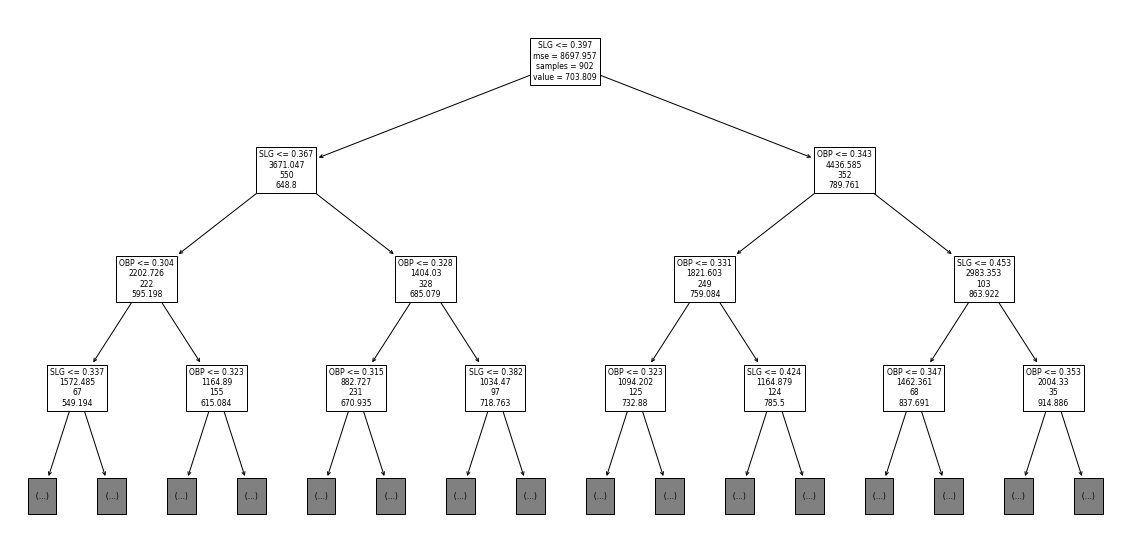

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
plt.figure(figsize=(20,10))
tree.plot_tree(moneyball_tree, label='root', max_depth=3,feature_names=['OBP','SLG','BA'])
plt.show()